In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import norm, skew
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from scipy.special import boxcox1p
import xgboost as xgb
import lightgbm as lgb
from rmsle import rmsle, rmsle_cv
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from stacking_average_models import StackingAveragedModels
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer, StandardScaler, Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
dim_red = False
imput = False

In [3]:
train_data = pd.read_csv("data/train.csv", index_col=False)
test_data = pd.read_csv("data/test.csv", index_col=False)
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [4]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
train_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [6]:
tr_id = train_data["Id"]
te_id = test_data["Id"]
tr_y = np.log1p(train_data["SalePrice"])
#te_y = test_data["SalePrice"]

In [7]:
train_data.drop("Id", axis = 1, inplace = True)
test_data.drop("Id", axis = 1, inplace = True)

In [8]:
distinct_values = {}
for column in train_data.columns:
    distinct_values[column]= train_data[column].nunique()
print(distinct_values)

{'MSSubClass': 15, 'MSZoning': 5, 'LotFrontage': 110, 'LotArea': 1073, 'Street': 2, 'Alley': 2, 'LotShape': 4, 'LandContour': 4, 'Utilities': 2, 'LotConfig': 5, 'LandSlope': 3, 'Neighborhood': 25, 'Condition1': 9, 'Condition2': 8, 'BldgType': 5, 'HouseStyle': 8, 'OverallQual': 10, 'OverallCond': 9, 'YearBuilt': 112, 'YearRemodAdd': 61, 'RoofStyle': 6, 'RoofMatl': 8, 'Exterior1st': 15, 'Exterior2nd': 16, 'MasVnrType': 4, 'MasVnrArea': 327, 'ExterQual': 4, 'ExterCond': 5, 'Foundation': 6, 'BsmtQual': 4, 'BsmtCond': 4, 'BsmtExposure': 4, 'BsmtFinType1': 6, 'BsmtFinSF1': 637, 'BsmtFinType2': 6, 'BsmtFinSF2': 144, 'BsmtUnfSF': 780, 'TotalBsmtSF': 721, 'Heating': 6, 'HeatingQC': 5, 'CentralAir': 2, 'Electrical': 5, '1stFlrSF': 753, '2ndFlrSF': 417, 'LowQualFinSF': 24, 'GrLivArea': 861, 'BsmtFullBath': 4, 'BsmtHalfBath': 3, 'FullBath': 4, 'HalfBath': 3, 'BedroomAbvGr': 8, 'KitchenAbvGr': 4, 'KitchenQual': 4, 'TotRmsAbvGrd': 12, 'Functional': 7, 'Fireplaces': 4, 'FireplaceQu': 5, 'GarageType':

In [9]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
data = pd.concat((train_data, test_data)).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)

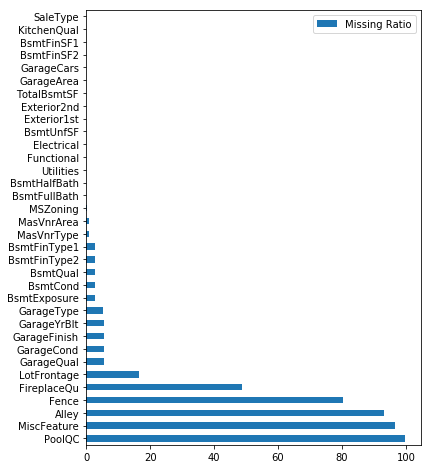

In [10]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.plot(kind="barh",figsize=(6,8))

In [11]:
data["PoolQC"] = data["PoolQC"].fillna("None")

In [12]:
data["MiscFeature"] = data["MiscFeature"].fillna("None")

In [13]:
data["Alley"] = data["Alley"].fillna("None")

In [14]:
data["Fence"] = data["Fence"].fillna("None")

In [15]:
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

In [16]:
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [17]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')

In [18]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)

In [19]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)

In [20]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')

In [21]:
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

In [22]:
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])

In [23]:
data = data.drop(['Utilities'], axis=1)

In [24]:
data["Functional"] = data["Functional"].fillna("Typ")

In [25]:
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

In [26]:
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])

In [27]:
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])

In [28]:
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

In [29]:
data['MSSubClass'] = data['MSSubClass'].fillna("None")

In [30]:
#Check remaining missing values if any 
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head()

,Missing Ratio


In [31]:
#MSSubClass=The building class
data['MSSubClass'] = data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
data['OverallCond'] = data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

In [32]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))
print('Shape all_data: {}'.format(data.shape))

Shape all_data: (2919, 78)


In [33]:
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

In [34]:
numeric_feats = data.dtypes[data.dtypes != "object"].index

skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


In [35]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    data[feat] = boxcox1p(data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [36]:
dummy_data = pd.get_dummies(data)
tr_df = dummy_data[:ntrain]
te_df = dummy_data[ntrain:]

In [37]:
tr_df.shape

(1460, 221)

In [38]:
tr_X = tr_df.values
te_X = te_df.values
tr_X.shape, te_X.shape

((1460, 221), (1459, 221))

In [39]:
if imput:
    my_imputer = Imputer()
    tr_X = my_imputer.fit_transform(tr_X)
    tr_X = StandardScaler().fit_transform(tr_X)
    tr_X = Normalizer().fit_transform(tr_X)
    te_X = my_imputer.fit_transform(te_X)
    te_X = StandardScaler().fit_transform(te_X)
    te_X = Normalizer().fit_transform(te_X)

In [40]:
if dim_red:
    pca = PCA(n_components=32)
    pca = pca.fit(tr_X, tr_X)
    tr_X = pca.transform(tr_X)
    te_X = pca.transform(te_X)

In [41]:
if 'SalePrice' in list(tr_df):
    raise

In [42]:
clf = MLPRegressor(random_state=9, max_iter=100000)
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/mlp_1_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.2325 (0.0164)



In [43]:
clf = MLPRegressor(random_state=9, hidden_layer_sizes=(32,8), max_iter=100000)
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/mlp_2_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 1.1924 (0.0269)



In [44]:
clf = SVR(kernel='poly', C=1e3, degree=1)
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/svr_1_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.1393 (0.0180)



In [45]:
clf = SVR(kernel='poly', C=1e3, degree=2)
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/svr_2_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.1555 (0.0131)



In [46]:
clf = SVR(kernel='poly', C=1e3, degree=3)
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/svr_3_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.1501 (0.0139)



In [47]:
clf = SVR()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/svr_4_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.1560 (0.0117)



In [48]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/random_forest_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.2185 (0.0099)



In [49]:
clf = linear_model.ARDRegression()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/ard_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.1336 (0.0171)



In [50]:
clf = linear_model.BayesianRidge()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/bayesian_ridge_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.1290 (0.0147)



In [51]:
clf = linear_model.ElasticNet(random_state=9)
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/elastic_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.3770 (0.0176)



In [52]:
clf = linear_model.HuberRegressor()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/huber_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.1308 (0.0170)



In [53]:
clf = linear_model.Lars()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/lars_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 190 iterations, i.e. alpha=2.104e-05, with an active set of 181 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 194 iterations, i.e. alpha=1.654e-05, with an active set of 184 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 194 iterations, i.e. alpha=1.638e-05, wit

/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 252 iterations, i.e. alpha=1.244e-02, with an active set of 200 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 252 iterations, i.e. alpha=1.224e-02, with an active set of 200 regressors, and the smallest cholesky pivot element being 6.747e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 252 iterations, i.e. alpha=9.602e-03, wit

Score: 450197681457837849283238316965804196732338176.0000 (900395362915675698566476633931608393464676352.0000)



In [54]:
clf = linear_model.Lasso()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/lasso_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.3992 (0.0159)



In [55]:
clf = linear_model.LassoLars()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/lasso_lars_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.3992 (0.0159)



In [56]:
clf = linear_model.LassoLarsIC()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/lasso_lars_ic_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 179 iterations, i.e. alpha=1.694e-05, with an active set of 165 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 197 iterations, i.e. alpha=5.989e-06, with an active set of 181 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well c

Score: 0.1349 (0.0179)



/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 207 iterations, i.e. alpha=4.978e-06, with an active set of 185 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 208 iterations, i.e. alpha=4.955e-06, with an active set of 186 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 215 iterations, i.e. alpha=2.478e-06, wit

In [57]:
clf = linear_model.LinearRegression(normalize=True, n_jobs=-1)
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/linear_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in expm1
  This is separate from the ipykernel package so we can avoid doing imports until


Score: 1941518545800.3599 (1687708150828.3491)



In [58]:
clf = linear_model.PassiveAggressiveRegressor()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/par_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.2017 (0.0527)



/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [59]:
clf = linear_model.RANSACRegressor()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/ransac_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 4055611.7709 (8111223.2279)



In [60]:
clf = linear_model.Ridge()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/ridge_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.1311 (0.0154)



In [61]:
clf = linear_model.SGDRegressor()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/sgd_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 1162244918620.1626 (403661872749.9680)



/Users/cenk/.virtualenvs/udacity/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [62]:
clf = linear_model.TheilSenRegressor()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/theil_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.2238 (0.0924)



In [63]:
clf = GradientBoostingRegressor()
clf = clf.fit(tr_X, tr_y)
te_y = np.expm1(clf.predict(te_X))

res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/gradient_boosting_%s.csv" %time.time(), index=False)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.1254 (0.0082)



In [64]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

score = rmsle_cv(ENet, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Score: 0.1240 (0.0165)



In [65]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

score = rmsle_cv(KRR, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Score: 0.1262 (0.0127)


In [66]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

score = rmsle_cv(lasso, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Score: 0.1240 (0.0165)


In [67]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

score = rmsle_cv(GBoost, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Score: 0.1248 (0.0130)


In [68]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

stacked_averaged_models.fit(tr_X, tr_y)
tr_pred = stacked_averaged_models.predict(tr_X)
stacked_pred = np.expm1(stacked_averaged_models.predict(te_X))

print(rmsle(tr_y, tr_pred))

0.0796922170484


In [69]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_xgb.fit(tr_X, tr_y)
xgb_pred = np.expm1(model_xgb.predict(te_X))

score = rmsle_cv(model_xgb, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Score: 0.1216 (0.0088)


In [70]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(tr_X, tr_y)
lgb_pred = np.expm1(model_lgb.predict(te_X))

score = rmsle_cv(model_lgb, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Score: 0.1247 (0.0101)


In [71]:
ensemble = stacked_pred*0.7 + xgb_pred*0.15 + lgb_pred*0.15
sub = pd.DataFrame()
sub['Id'] = te_id
sub['SalePrice'] = ensemble
sub.to_csv('results/ensemble.csv',index=False)

In [73]:
from tensorflow.contrib.keras.python.keras.layers import Dense
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.wrappers.scikit_learn import KerasRegressor

def create_model():
    global input_dim
    model = Sequential()
    model.add(Dense(int(input_dim / 2), input_dim=input_dim, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(int(input_dim / 4), kernel_initializer='normal', activation='tanh'))
    model.add(Dense(int(input_dim / 8), kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

input_dim = tr_X.shape[1]

clf = KerasRegressor(build_fn=create_model, epochs=100, batch_size=5, verbose=0)
clf.fit(tr_X, tr_y)

score = rmsle_cv(clf, tr_X, tr_y)
print("Score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

te_y = np.expm1(clf.predict(te_X))
res = pd.DataFrame({"Id": te_id, "SalePrice": te_y.reshape(te_y.shape[0])})
res.to_csv("results/dnn_regression.csv", index=False)

Score: 0.2705 (0.0106)
